#### librerias

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split

## Parte 1

La primera parte del proyecto estara centrada en la prediccion categorica de canciones, se quiere predecir si una cancion con x caracteristicas puede ser de agrado para un agente Y. Esto tratara de imitar el modelo de seleccion de canciones nuevas que plataformas como Spotify, Apple music y demas productos de streaming ofrecen al usuario como nuevas alternativas musicales o descubrimientos musicales.

La informacion fue extraida de la API de Spotify para un agente X, con el cual trataremos de hacer un modelo que nos pueda aprender la relacion entre las caracteristicas de una cancion y el gusto musical de nuestro agente X, con el fin de poder en un futuro se pueda seleccionar un grupo de canciones, pasarlar por le modelo para obtener las que le gustarian a nuestro agente X y asi poder compartirle "nuevas canciones" que seran de su agrado. 

El modelo en si es basicamente funcionara como un sistema de recomendacion.

#### Dataset

In [ ]:
raw_dataset1 = pd.read_csv("parte1/data.csv", index_col=0)

El dataset consiste en un set de canciones reproducidas sobre un agente X, por cada cancion contamos con 15 features que provee spotify y la variable respuesta que indica si la cancion tuvo fue de agrado para el agente o no.

**Variables:**
* acousticness: valor entre 0 y 1 que indica que tan acustica es una cancion.
* danceability: valor entre 0 y 1 que indica que tan indicada es la cancion para bailar, esto es medido a partir del tempo, ritmo, fuerza de los tonos.
* duration_ms: Durations de la cancion en milisegundos.
* energy: valor entre 0 y 1 que mide la velocidad, lo ruidoso y el alto tono de la cancion.
* instrumentalness: valor entre 0 y 1 que mide que tan instrumental es la cancion al verificar la ausencia de sonidos vocales.
* key: la llave de la cancion.
* liveness: valor entre 0 y 1 que detenta la presencia de audiencia en la cancion.
* loudness: valor entre -60 y 0 que mide los decibeles de volumen de la cancion.
* mode: entero entre 0 y 1 que indica la modalidad (mayor o menor) de una cancion basado en que tipo de escala es derivada la cancion.
* speechiness: valor entre 0 y 1 que detecta la presencia de palabras en la cancion.
* tempo: indica el tempo estimado de toda la cancion en tonos por minuto.
* time_signature: indica cuantos tonos hay en una barra.
* valence: valor entre 0 y 1 para describir la positividad de la cancion.
* song_title: nombre de la cancion
* artist: nombre del artista de la cancion

**Variable Respuesta:**
* target: Indica con 1 si tuvo like y 0 si no.

In [ ]:
raw_dataset1.head(5)

In [ ]:
raw_dataset1.columns

Debido a que el dataset contiene variables identificadoras, estas seran eliminadas y ya que es un dataset que se obtuvo a traves del API de spotify las variables categoricas ya han sido convertidas a numericas, siendo estas representadas por numeros enteros. A continuacion se hara el split entre los conjuntos de entrenamiento y de prueba.

In [ ]:
dataset1 = raw_dataset1[['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target']]

In [ ]:
train, test_validation = train_test_split(dataset1, test_size=0.6, random_state=42)
test, validation = train_test_split(test_validation, test_size=0.5, random_state=42)

train_ds = torch.utils.data.TensorDataset(torch.tensor(train.drop('target', axis=1).values.astype(np.float32)), 
                                       torch.tensor(train['target'].values.astype(np.float32)))

test_ds = torch.utils.data.TensorDataset(torch.tensor(test.drop('target', axis=1).values.astype(np.float32)), 
                                       torch.tensor(test['target'].values.astype(np.float32)))

validation_ds = torch.utils.data.TensorDataset(torch.tensor(validation.drop('target', axis=1).values.astype(np.float32)), 
                                       torch.tensor(validation['target'].values.astype(np.float32)))
# dataset1_features = torch.tensor(dataset1.drop('target', axis=1).values.astype(np.float32))
# dataset1_target = torch.tensor(dataset1['target'].values.astype(np.float32))

# dataset1_tensor = torch.utils.data.TensorDataset(dataset1_features, dataset1_target)

# tp, te, vp = int(dataset1.shape[0] * 0.6), int(dataset1.shape[0] * 0.2), int(dataset1.shape[0] * 0.2) + 1
# train, test_validation = torch.utils.data.random_split(dataset1_tensor, [tp, te + vp], generator=torch.Generator().manual_seed(42))
# test, validation = torch.utils.data.random_split(test_validation, [te,vp], generator=torch.Generator().manual_seed(42))

## Experimentacion

In [ ]:
def train(model, train, test, batch_size, lr, optimizer, loss_fn, epochs, description, verbose=10):
    model = model()
    loss_fn = loss_fn()
    optimizer = optimizer(model.parameters(), lr=lr)        
    train_dataloader = DataLoader(train_ds, batch_size=batch_size)
    test_dataloader = DataLoader(test_ds, batch_size=batch_size)
    
    
    losses = []
    accs = []
    for t in range(epochs):
        for batch, (X, y) in enumerate(train_dataloader):
            pred = model(X)
            loss = loss_fn(pred, y.reshape(-1, 1))
            acc = model.acc_calc(pred, y.reshape(-1, 1))

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        test_acc = model.test(test_dataloader)
        losses.append(loss.item())
        accs.append(test_acc.item())

        if t % verbose == 0:
            print(f"Epoch {t+1}\n-------------------------------")
            print(f"loss: {loss:>7f} | accuracy: {acc:>2f} | validation_accuracy: {test_acc: >2f}")
    print("Done!")
    
    # Saving the model
    torch.save(model.state_dict(), f'./parte1/experiments/{description}_batch={batch_size}_lr={str(lr)[2:]}_epochs={epochs}.pth')
            
    # Returning losses and accuracy metrics through training 
    return losses, accs

#### Arquitectura 1

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
        torch.nn.init.xavier_uniform_(self.layer_1.weight)
        torch.nn.init.zeros_(self.layer_1.bias)
        torch.nn.init.xavier_uniform_(self.layer_2.weight)
        torch.nn.init.zeros_(self.layer_2.bias)
        torch.nn.init.xavier_uniform_(self.layer_out.weight)
        torch.nn.init.zeros_(self.layer_out.bias)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
    def acc_calc(self, y_pred, y_test):
        y_pred_tag = torch.round(torch.sigmoid(y_pred))
        correct_results_sum = (y_pred_tag == y_test).sum().float()
        acc = correct_results_sum/y_test.shape[0]
        return acc * 100
    
    def test(self, dataloader):
        correct = 0
        with torch.no_grad():
            for batch, (X, y) in enumerate(dataloader):
                pred = self.forward(X)
                pred = torch.round(torch.sigmoid(pred))
                correct += (pred == y.reshape((-1,1))).sum().float()
            return correct / len(dataloader.dataset) * 100

In [ ]:
losses, accs = train(NN, train_ds, test_ds, 64, 0.0001, 
                      torch.optim.Adam, nn.BCEWithLogitsLoss, 100, 
                     'NN_relu_drop_out_xavier', 10)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

In [ ]:
losses, accs = train(NN, train_ds, test_ds, 64, 0.001, 
                      torch.optim.Adam, nn.BCEWithLogitsLoss, 100, 
                     'NN_relu_drop_out_xavier', 10)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

In [ ]:
losses, accs = train(NN, train_ds, test_ds, 128, 0.00001, 
                      torch.optim.Adam, nn.BCEWithLogitsLoss, 200, 
                     'NN_relu_drop_out_xavier', 10)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

In [ ]:
losses, accs = train(NN, train_ds, test_ds, 128, 0.00001, 
                      torch.optim.Adamax, nn.BCEWithLogitsLoss, 200, 
                     'NN_relu_drop_out_xavier', 10)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

### Arquitectura 2

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
        torch.nn.init.xavier_uniform_(self.layer_1.weight)
        torch.nn.init.zeros_(self.layer_1.bias)
        torch.nn.init.xavier_uniform_(self.layer_2.weight)
        torch.nn.init.zeros_(self.layer_2.bias)
        torch.nn.init.xavier_uniform_(self.layer_out.weight)
        torch.nn.init.zeros_(self.layer_out.bias)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
    def acc_calc(self, y_pred, y_test):
        y_pred_tag = torch.round(torch.sigmoid(y_pred))
        correct_results_sum = (y_pred_tag == y_test).sum().float()
        acc = correct_results_sum/y_test.shape[0]
        return acc * 100
    
    def test(self, dataloader):
        correct = 0
        with torch.no_grad():
            for batch, (X, y) in enumerate(dataloader):
                pred = self.forward(X)
                pred = torch.round(torch.sigmoid(pred))
                correct += (pred == y.reshape((-1,1))).sum().float()
            return correct / len(dataloader.dataset) * 100

In [ ]:
losses, accs = train(NN, train_ds, test_ds, 128, 0.00001, 
                      torch.optim.Adamax, nn.BCEWithLogitsLoss, 200, 
                     'NN_relu_drop_out_batchnorm_xavier', 10)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

In [ ]:
losses, accs = train(NN, train_ds, test_ds, 128, 0.001, 
                      torch.optim.Adam, nn.BCEWithLogitsLoss, 300, 
                     'NN_relu_drop_out_batchnorm_xavier', 20)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

In [ ]:
losses, accs = train(NN, train_ds, test_ds, 128, 0.00001, 
                      torch.optim.Adamax, nn.BCEWithLogitsLoss, 200, 
                     'NN_relu_drop_out_xavier', 10)

f, (ax1, ax2) = plt.subplots(2, 1, sharey=False)
ax1.plot(np.arange(len(losses)), losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(np.arange(len(accs)), accs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

#### Validation

In [ ]:
ld = NN()
ld.load_state_dict(torch.load("./parte1/experiments/NN_relu_drop_out_xavier_batch=64_lr=0001_epochs=100.pth"))
ld.test(DataLoader(test_ds, batch_size=))

#### Conclusiones

## Parte 2

#### librerias

In [1]:
from tensorflow.keras.layers     import Conv2D, Flatten, Dense, MaxPool2D
from sklearn.metrics             import classification_report
from sklearn.model_selection     import train_test_split
from tensorflow.keras            import Sequential
from sklearn.metrics             import confusion_matrix


import matplotlib.pyplot as plt
import pandas            as pd
import numpy             as np
import cv2
import os

In [ ]:
image = cv2.imread('../paris.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#### Dataset

#### Data Preparation

In [ ]:
labels = pd.read_csv('./parte2/data/labels.csv')

In [ ]:
dataset = []
lbls = []

def rescale_frame(frame, percent=75):
    dim = (536, 356)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

for asset in os.listdir('./parte2/data/photos'):
    label = labels[labels['ID'] == int(asset.replace(".png", ""))] \
                .drop(columns=['ID', 'Disease_Risk']) \
                .to_numpy()[0]
    tmp = cv2.imread(f'./parte2/data/photos/{asset}')
    rescaled_tmp = rescale_frame(tmp, 25)
    dataset.append(rescaled_tmp)
    lbls.append(label)
    
dataset = np.array(dataset)
lbls = np.array(lbls)

np.save('D:/parte2/data/features.npy', dataset)
np.save('D:/parte2/data/labels.npy', lbls)
print('Done!')

In [ ]:
features = np.load('D:/parte2/data/features.npy', allow_pickle=True)
labels = np.load('D:/parte2/data/labels.npy', allow_pickle=True)
features.shape, labels.shape

In [ ]:
plt.imshow(features[0])
plt.show()

#### Definicion arquitectura

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4, random_state=42)
x_test, x_validation, y_test, y_validation = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
x_train.shape, x_test.shape, x_validation.shape, y_train.shape, y_test.shape, y_validation.shape

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(356, 536, 3), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Flatten())
cnn.add(Dense(units=64, activation='relu'))
cnn.add(Dense(units=45, activation='sigmoid'))
# cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnn.fit(x_train, y_train, epochs=2)

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


#### Experimentacion

In [ ]:
def train(model, train, test, batch_size, optimizer, loss_fn, epochs, description):
    filepath = f'./parte2/experiments/{description}_batch={batch_size}_epochs={epochs}'
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=1, save_weights_only=1, mode='max')
    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    x_train, y_train = train[0], train[1]
    x_test, y_test = test[0], test[1]
    
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint_callback])
    
    print("Done!")
    return history.history

In [ ]:
train_params = train(cnn, [x_train, y_train], [x_test, y_test], 64, 'adam', 'categorical_crossentropy', 1, 
      'conv64_maxpool2_conv32_maxpool2_relu64_sigmoid45')

In [ ]:
train_params.keys()

#### Conclusiones

## Parte 3

In [148]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#### Dataset

./parte3/data/coin_Cardano.csv


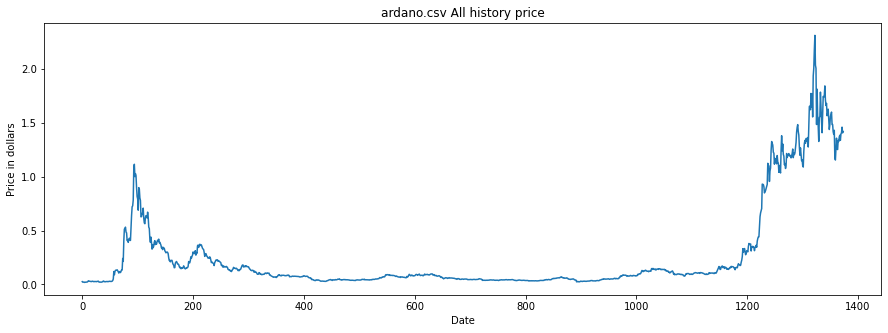

./parte3/data/coin_ChainLink.csv


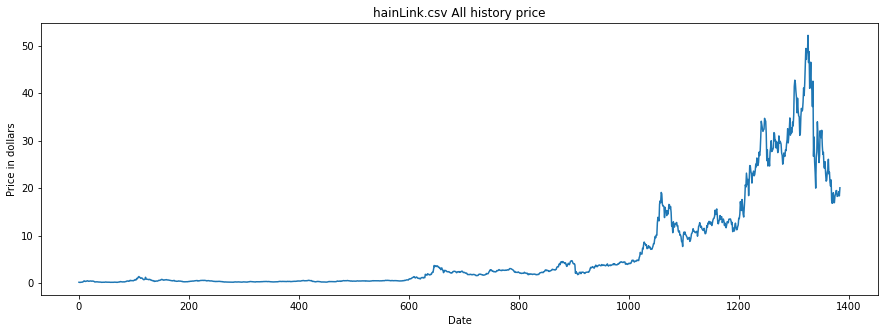

./parte3/data/coin_Cosmos.csv


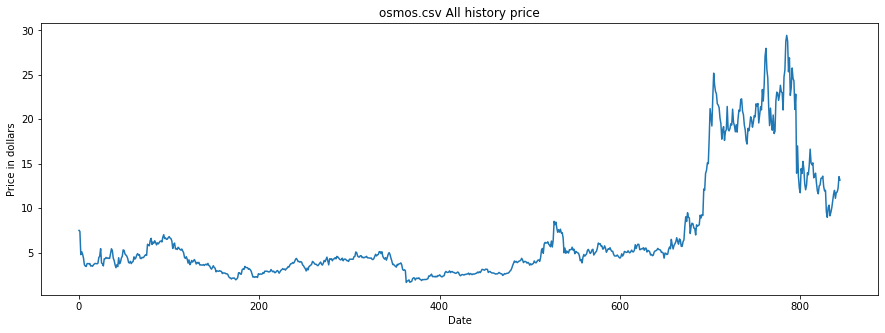

./parte3/data/coin_CryptocomCoin.csv


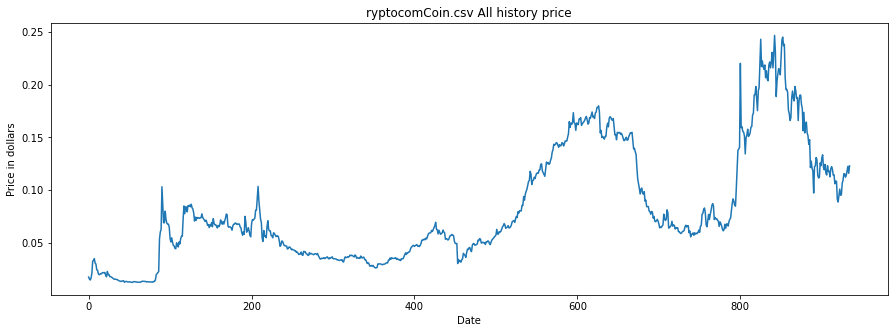

./parte3/data/coin_Dogecoin.csv


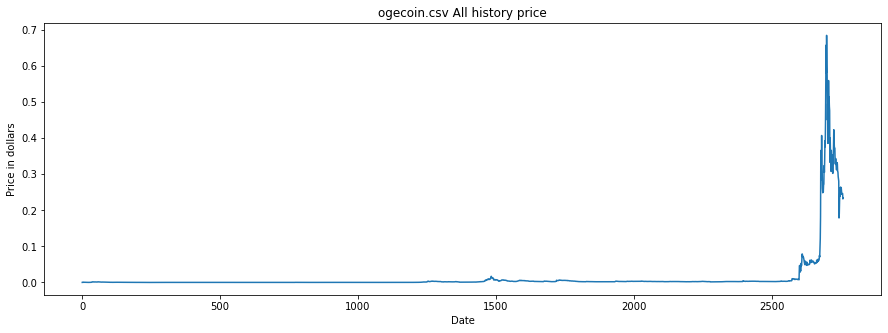

./parte3/data/coin_EOS.csv


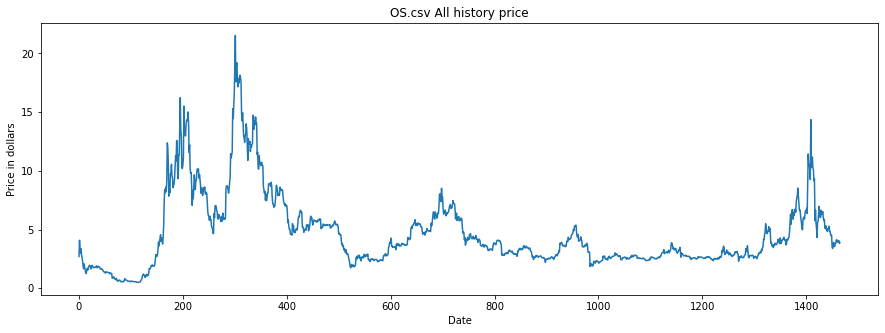

./parte3/data/coin_Ethereum.csv


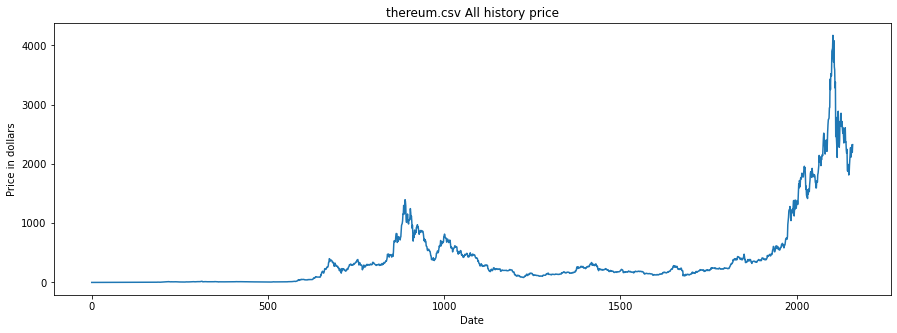

./parte3/data/coin_Iota.csv


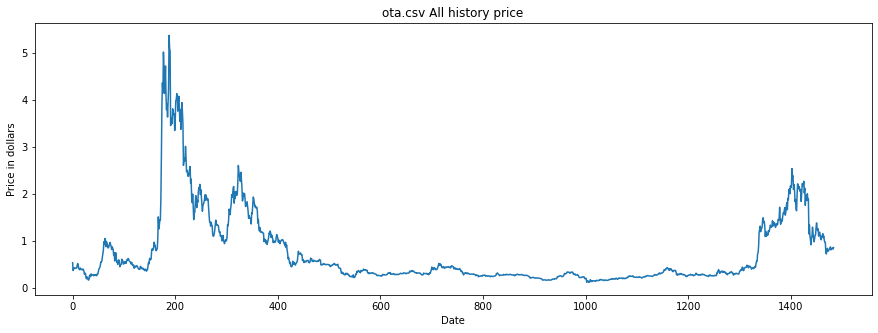

./parte3/data/coin_Litecoin.csv


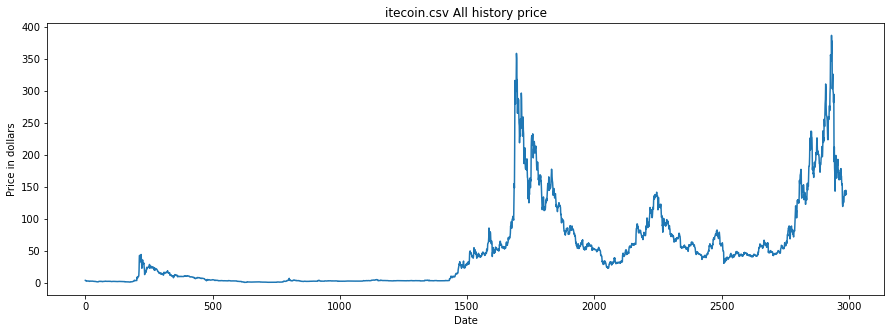

./parte3/data/coin_Monero.csv


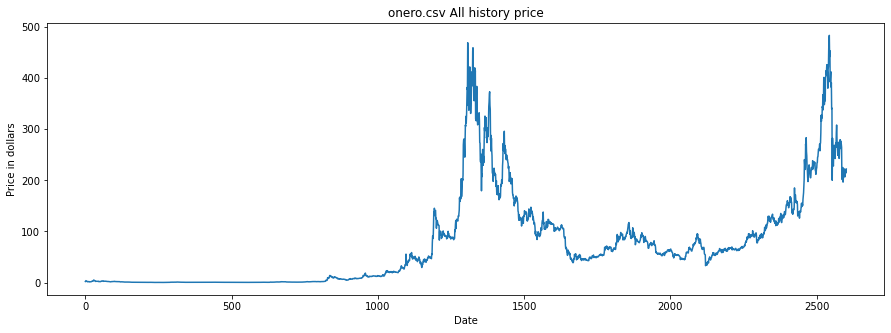

./parte3/data/coin_NEM.csv


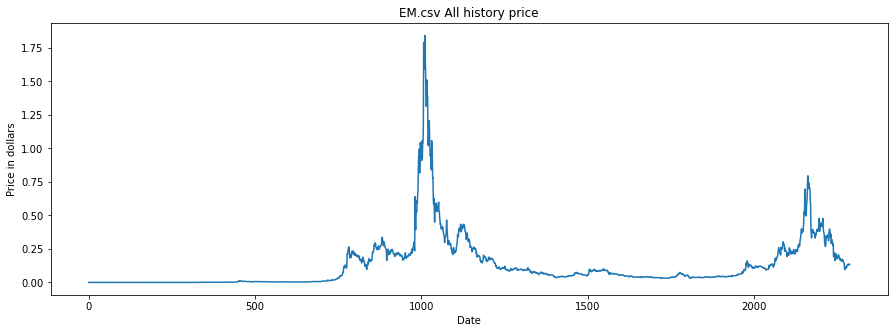

./parte3/data/coin_Polkadot.csv


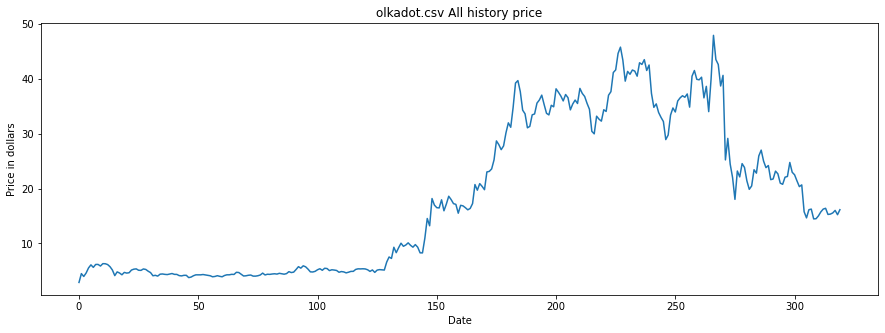

./parte3/data/coin_Solana.csv


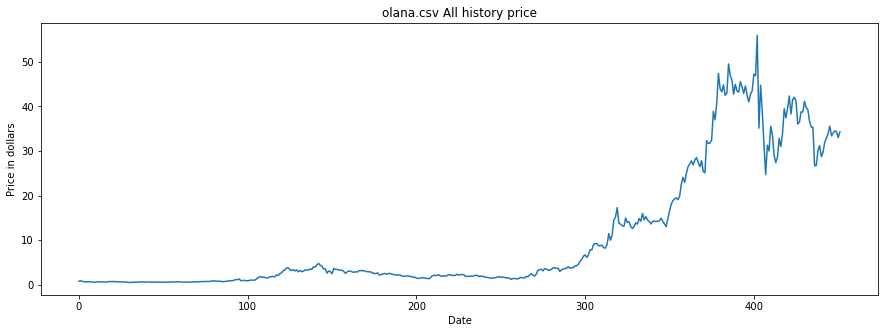

./parte3/data/coin_Stellar.csv


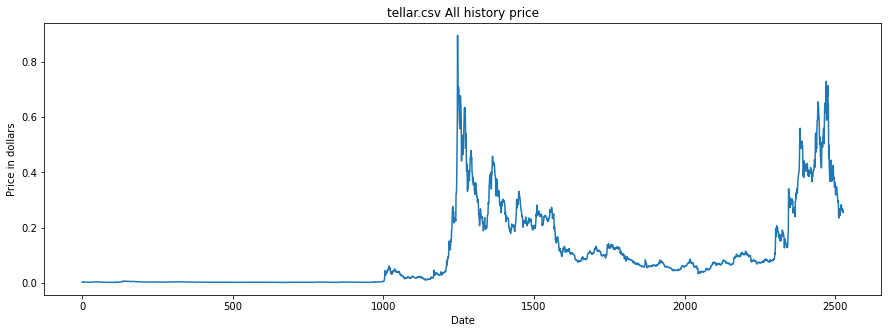

./parte3/data/coin_Tether.csv


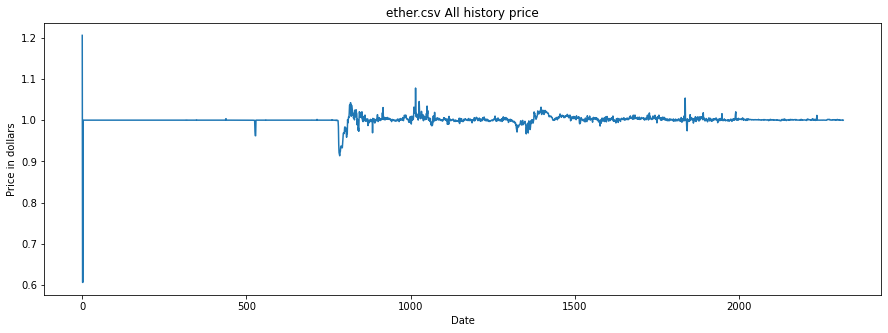

./parte3/data/coin_Tron.csv


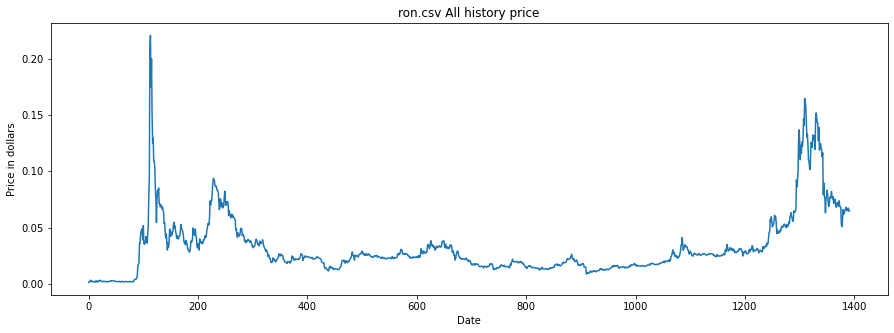

./parte3/data/coin_Uniswap.csv


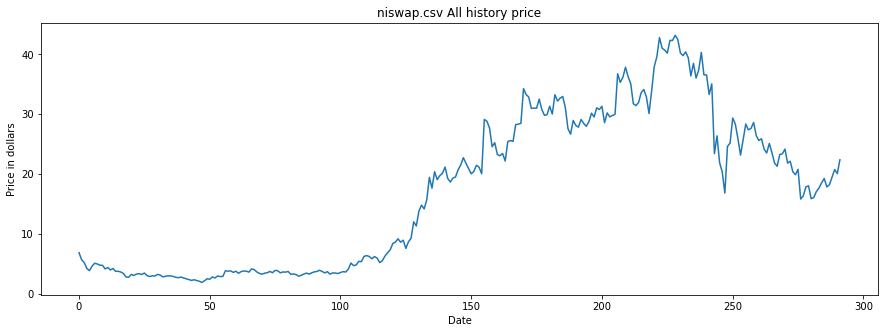

./parte3/data/coin_USDCoin.csv


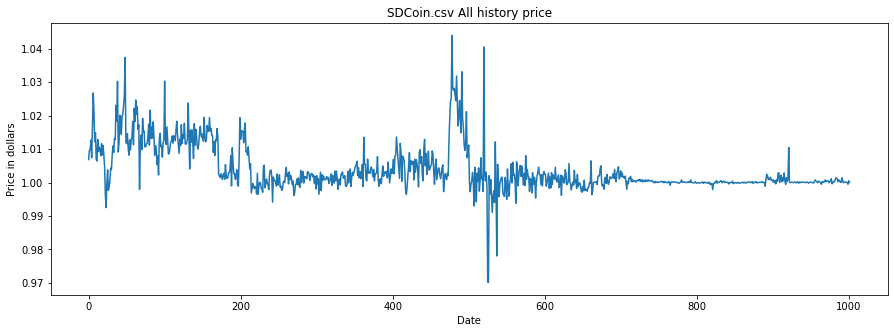

./parte3/data/coin_WrappedBitcoin.csv


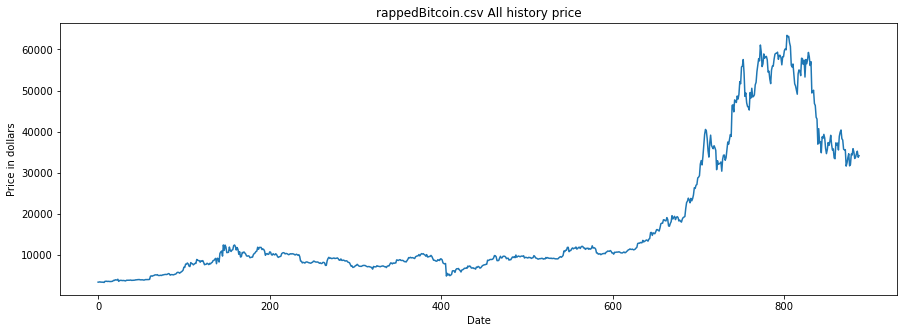

./parte3/data/coin_XRP.csv


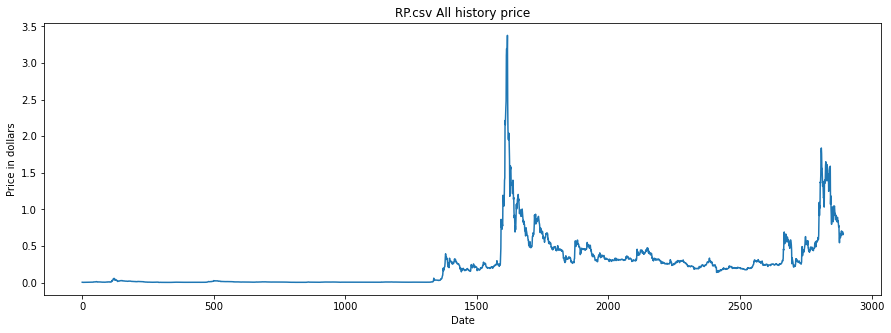

./parte3/data/data.csv


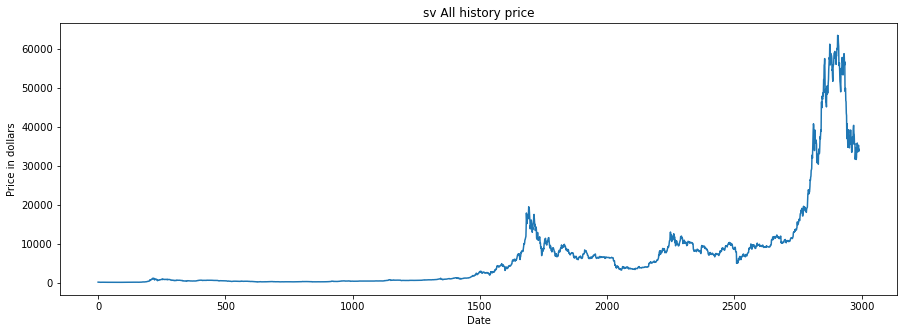

In [120]:
for coin in os.listdir('./parte3/data/'):
    print(f'./parte3/data/{coin}')
    raw = pd.read_csv(f'./parte3/data/{coin}')
    dataset = raw[['Date', 'Close']].rename(columns={'Close': 'Price'})
    dataset['Date'] = dataset['Date'].apply(lambda x: str(x)[:10])
    plt.figure(figsize=(15, 5))
    plt.plot(dataset['Price'])
    plt.xlabel('Date')
    plt.ylabel('Price in dollars')
    plt.title(f'{coin[6:]} All history price')
    plt.show()

In [161]:
raw = pd.read_csv("./parte3/data/data.csv")
dataset = raw[['Date', 'Close']].rename(columns={'Close': 'Price'})
dataset['Date'] = dataset['Date'].apply(lambda x: str(x)[:10])
dataset.head()

,Date,Price
0,2013-04-29,144.539993
1,2013-04-30,139.000000
2,2013-05-01,116.989998
3,2013-05-02,105.209999
4,2013-05-03,97.750000


In [162]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset['Price'] = scaler.fit_transform(dataset[['Price']])
dataset.head()

,Date,Price
0,2013-04-29,0.001200
1,2013-04-30,0.001112
2,2013-05-01,0.000765
3,2013-05-02,0.000580
4,2013-05-03,0.000462


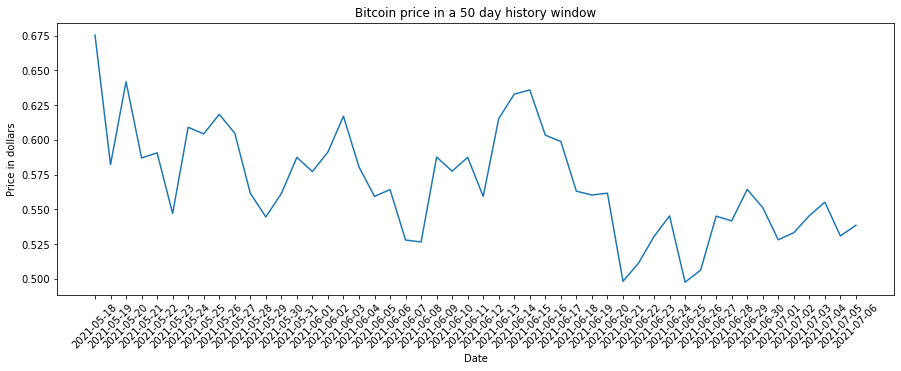

In [163]:
window = 50
plt.figure(figsize=(15, 5))
plt.plot(dataset['Date'][-window:], dataset['Price'][-window:])
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.xticks(rotation=45)
plt.title(f'Bitcoin price in a {window} day history window')
plt.show()

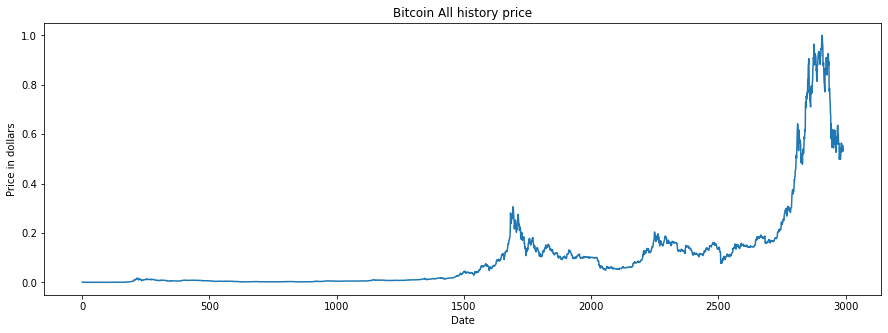

In [164]:
plt.figure(figsize=(15, 5))
plt.plot(dataset['Price'])
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.title(f'Bitcoin All history price')
plt.show()

In [165]:
x_window = 5
y_window = 1
x = []
y = []

for x_w in range(0, len(dataset['Price']) - x_window - y_window - 1, x_window + y_window):
    x.append(dataset['Price'][x_w: x_w + x_window])
    y.append(dataset['Price'][x_w + x_window: x_w + x_window + y_window])
    
x, y = np.array(x), np.array(y)
x = x.reshape((x.shape[0], 1, x_window))
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, shuffle = False, stratify = None)
x_test, x_validation, y_test, y_validation = train_test_split(x_temp, y_temp, test_size=0.5, shuffle = False, stratify = None)

#### Definicion arquitectura

In [166]:
model = Sequential()
model.add(LSTM(5, input_shape=(1, x_window)))
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

Epoch 1/100
3/3 [==============================] - 3s 479ms/step - loss: 0.0022 - val_loss: 0.0073
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 8/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 9/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.0031
Epoch 10/100
3/3 [==============================] - 0s 13ms/step - loss: 9.2209e-04 - val_loss: 0.0027
Epoch 11/100
3

3/3 [==============================] - 0s 12ms/step - loss: 1.7229e-04 - val_loss: 6.9507e-05
Epoch 79/100
3/3 [==============================] - 0s 12ms/step - loss: 7.5967e-05 - val_loss: 6.2117e-05
Epoch 80/100
3/3 [==============================] - 0s 13ms/step - loss: 2.4654e-04 - val_loss: 6.2396e-05
Epoch 81/100
3/3 [==============================] - 0s 12ms/step - loss: 1.2935e-04 - val_loss: 7.2117e-05
Epoch 82/100
3/3 [==============================] - 0s 12ms/step - loss: 6.8103e-05 - val_loss: 9.3229e-05
Epoch 83/100
3/3 [==============================] - 0s 12ms/step - loss: 1.0258e-04 - val_loss: 1.8874e-04
Epoch 84/100
3/3 [==============================] - 0s 11ms/step - loss: 9.4609e-05 - val_loss: 1.8848e-04
Epoch 85/100
3/3 [==============================] - 0s 12ms/step - loss: 1.5731e-04 - val_loss: 1.2916e-04
Epoch 86/100
3/3 [==============================] - 0s 12ms/step - loss: 8.4544e-05 - val_loss: 1.0341e-04
Epoch 87/100
3/3 [==============================] 

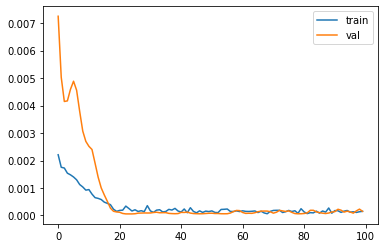

In [167]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=128, verbose=1, validation_data=(x_test, y_test))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.show()

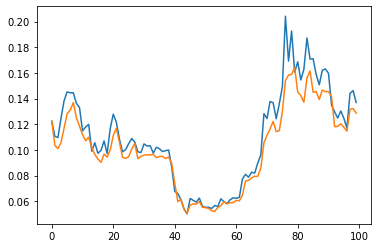

In [168]:
test_predictions = model.predict(x_test)
plt.plot(y_test)
plt.plot(test_predictions)
plt.show()

#### Experimentacion

#### Conclusiones